# Исследовательский анализ данных

# Computer Vision Project (Photo Processing )

The retail supermarket chain is implementing a computer vision system to process customer photographs. Capturing images in the checkout area will help determine the age of customers in order to:

- Analyze purchasing patterns and suggest products that may interest customers in a particular age group;
- Ensure cashiers' compliance with age-restricted product sales, such as alcohol.

In this project we build a model that can estimate a person's approximate age based on a photograph. 

The data is sourced from the ChaLearn Looking at People website. 
Datasets are stored in `/final_files` and a CSV file `labels.csv` with two columns: `file_name` and `real_age`.

## Data upload

Import libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import image_dataset_from_directory

Upload data

In [2]:
labels_df = pd.read_csv('/datasets/faces/labels.csv')

In [3]:
labels_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


- The dataset has two columns: `file_name` and `real_age`
- 7,591 records
- No missing values
- Data format is in order

In [3]:
labels_df.head(3)

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80


## Exploratory Data Analysis

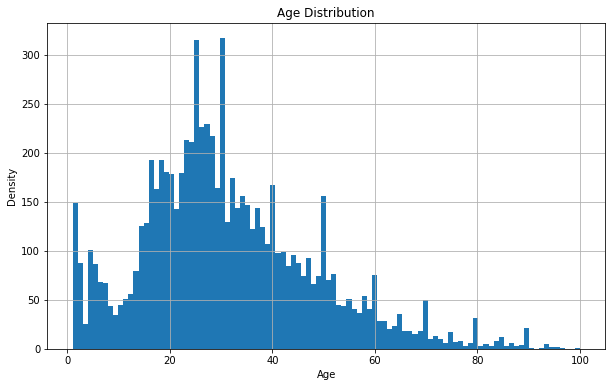

In [3]:
plt.figure(figsize=(10, 6))
labels_df['real_age'].hist(bins=100)
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Density')
plt.show()


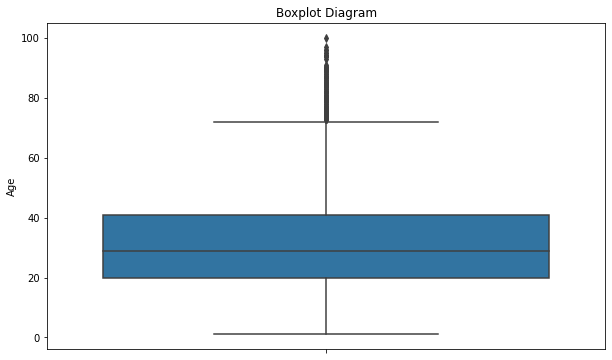

In [4]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=labels_df, y='real_age')
plt.title('Boxplot Diagram')
plt.ylabel('Age')
plt.show()

**Age Distribution Analysis in the Dataset**

- The primary age range in the dataset is between 20 and 40 years.
- A significant peak can be observed between the ages of 20 to 25, suggesting frequent store visits by individuals in this age group.
- From the age of 30-35, the frequency of visits gradually decreases.
- The distribution shows a smooth decline as age increases, with the sample size becoming negligible around ages 50-60.
- Outliers are noticeable in the age range of 70 and above.
- There is also a peak for very young children aged 1-2 years, who may not be potential buyers themselves, but the model will nonetheless consider them.

## Photos display

Load potos using flow_from_dataframe

In [6]:
image_directory = "/datasets/faces/final_files/"

datagen = ImageDataGenerator(rescale=1.0/255)

data_generator = datagen.flow_from_dataframe(
    dataframe=labels_df,
    directory=image_directory,
    x_col="file_name",
    y_col="real_age",
    target_size=(150, 150),
    batch_size=32,
    class_mode="raw"  
)


Found 7591 validated image filenames.


Display first 15 photos of the sample

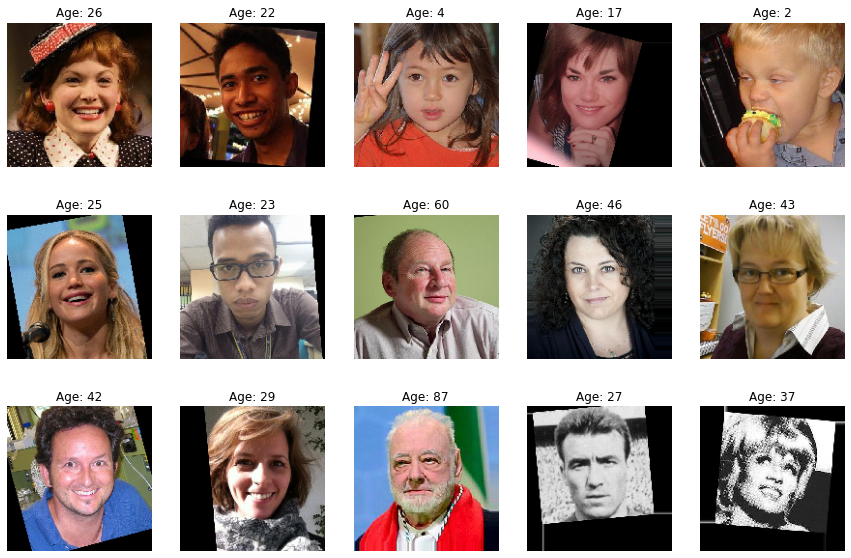

In [7]:
images, ages = next(data_generator)

plt.figure(figsize=(15, 10))
for i in range(15):  
    ax = plt.subplot(3, 5, i + 1)
    plt.imshow(images[i])
    plt.title(f"Age: {int(ages[i])}")
    plt.axis("off")
plt.show()

After examining the data, it can be concluded that the group of younger customers dominates over the older age group. This may affect the model's predictions, as predictions for the older age group may not be as accurate. 

**Conclusion**

The dataset contains a total of 7,591 images, which is a sufficient volume for initial training.

After examining the data distribution, we can conclude that the age group of young customers significantly outweighs the older group. The histogram shows a high frequency of observations in the age range up to 40 years, while the number of examples for people over 50 is considerably lower. This skew toward younger age groups may affect the model’s accuracy in predicting the age of older individuals.

This imbalance in the data could cause the model to be optimized for the more common age group—young people—which might impact its generalizability and reduce accuracy for less represented age categories. Specifically, the model might tend to underestimate the age predictions for older people, as it will be better trained on examples of younger age groups.

To improve the model, it would be beneficial to address the data imbalance, such as by adding more examples for older age categories or applying data augmentation techniques specifically for the older age group.

Regarding the photos themselves, we can observe that people are captured from different angles and with varying facial expressions. This variability increases the complexity of the model’s task, particularly in recognizing age-related features.

Another factor that might complicate training is image quality: some photos appear sharp and bright, while others are dark or blurred.

Additionally, background complexity can be an issue; some images have complex or distracting backgrounds, which may also hinder model training.

On the positive side, the dataset includes people of different genders and ethnicities, which adds diversity. This could help the model learn to recognize age features that are universal across all groups, which is important for the model’s generalizability.

## Model Training

In [8]:
import pandas as pd
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.optimizers import Adam

# Function to load and preprocess the training data
def load_train(path):
    # Load the CSV file containing file names and real ages
    labels_df = pd.read_csv(os.path.join(path, 'labels.csv'))
    
    # Initialize an ImageDataGenerator with rescaling and validation split
    datagen = ImageDataGenerator(
        rescale=1.0/255,           # Normalize pixel values to range [0,1]
        validation_split=0.25      # Reserve 25% of data for validation
    )
    
    # Generate the training data from the dataframe
    train_data = datagen.flow_from_dataframe(
        dataframe=labels_df,
        directory=os.path.join(path, 'final_files'),  # Directory with images
        x_col='file_name',                            # Column with file names
        y_col='real_age',                             # Column with age labels
        target_size=(150, 150),                       # Resize images to 150x150
        batch_size=32,                                # Batch size
        class_mode='raw',                             # Use 'raw' for regression
        subset='training',                            # Use training subset
        seed=42                                       # Seed for reproducibility
    )
    
    return train_data

# Function to load and preprocess the test (validation) data
def load_test(path):
    # Load the CSV file containing file names and real ages
    labels_df = pd.read_csv(os.path.join(path, 'labels.csv'))
    
    # Initialize an ImageDataGenerator with rescaling and validation split
    datagen = ImageDataGenerator(
        rescale=1.0/255,           # Normalize pixel values to range [0,1]
        validation_split=0.25      # Reserve 25% of data for validation
    )
    
    # Generate the validation data from the dataframe
    test_data = datagen.flow_from_dataframe(
        dataframe=labels_df,
        directory=os.path.join(path, 'final_files'),  # Directory with images
        x_col='file_name',                            # Column with file names
        y_col='real_age',                             # Column with age labels
        target_size=(150, 150),                       # Resize images to 150x150
        batch_size=32,                                # Batch size
        class_mode='raw',                             # Use 'raw' for regression
        subset='validation',                          # Use validation subset
        seed=42                                       # Seed for reproducibility
    )
    
    return test_data

# Function to create the model architecture
def create_model(input_shape=(224, 224, 3)):  
    # Load the ResNet50 model with pre-trained ImageNet weights, excluding top layers
    backbone = ResNet50(
        weights='imagenet',
        include_top=False,
        input_shape=input_shape
    )
    
    # Unfreeze the last 10 layers of ResNet50 for fine-tuning
    for layer in backbone.layers[-10:]:  
        layer.trainable = True

    # Build a new model on top of ResNet50
    model = Sequential([
        backbone,                     # Add ResNet50 as the base
        GlobalAveragePooling2D(),     # Pooling layer to reduce output dimensions
        Dense(128, activation='relu'),# Fully connected layer with 128 units
        Dropout(0.5),                 # Dropout layer for regularization
        Dense(1)                      # Output layer for age prediction
    ])

    # Compile the model with Adam optimizer, MSE loss, and MAE metric
    model.compile(
        optimizer=Adam(learning_rate=0.00001),  # Lower learning rate for fine-tuning
        loss='mse',                             # MSE loss for regression
        metrics=['mae']                         # MAE metric for evaluation
    )
    
    return model

# Function to train the model
def train_model(model, train_data, test_data, batch_size=None, epochs=50, steps_per_epoch=None, validation_steps=None):
    # Train the model with the specified parameters
    history = model.fit(
        train_data,
        validation_data=test_data,
        batch_size=batch_size,
        epochs=epochs,
        steps_per_epoch=steps_per_epoch,
        validation_steps=validation_steps,
        verbose=2  # Display detailed logging for each epoch
    )
    
    return model


All calculations were  performed on a server with a graphics card (GPU) in the Yandex Compute Cloud. Here is a log of the model training run: 


Epoch 5/50
178/178 - 46s - loss: 60.4366 - mae: 5.9536 - val_loss: 127.0778 - val_mae: 8.7995
Epoch 6/50
178/178 - 47s - loss: 54.7968 - mae: 5.5715 - val_loss: 103.0561 - val_mae: 7.8435
Epoch 7/50
178/178 - 46s - loss: 52.3341 - mae: 5.4196 - val_loss: 101.3764 - val_mae: 7.6961
Epoch 8/50
178/178 - 46s - loss: 50.3509 - mae: 5.3283 - val_loss: 99.1807 - val_mae: 7.6253
Epoch 9/50
178/178 - 46s - loss: 46.6411 - mae: 5.1407 - val_loss: 98.3631 - val_mae: 7.5751
Epoch 10/50
178/178 - 47s - loss: 44.1664 - mae: 5.0160 - val_loss: 99.7437 - val_mae: 7.5788
Epoch 11/50
178/178 - 47s - loss: 45.0287 - mae: 5.0338 - val_loss: 96.7928 - val_mae: 7.5670
Epoch 12/50
178/178 - 47s - loss: 43.2098 - mae: 4.9511 - val_loss: 96.8818 - val_mae: 7.5892
Epoch 13/50
178/178 - 47s - loss: 42.1520 - mae: 4.8665 - val_loss: 96.0207 - val_mae: 7.5933
Epoch 14/50
178/178 - 46s - loss: 41.2886 - mae: 4.8041 - val_loss: 93.4636 - val_mae: 7.3699
Epoch 15/50
178/178 - 46s - loss: 39.2152 - mae: 4.6317 - val_loss: 95.6680 - val_mae: 7.4980
Epoch 16/50
178/178 - 46s - loss: 37.0999 - mae: 4.5936 - val_loss: 92.5261 - val_mae: 7.3077
Epoch 17/50
178/178 - 47s - loss: 36.7183 - mae: 4.5442 - val_loss: 95.5640 - val_mae: 7.3264
Epoch 18/50
178/178 - 45s - loss: 35.9935 - mae: 4.4280 - val_loss: 93.3967 - val_mae: 7.2772
Epoch 19/50
178/178 - 43s - loss: 35.1538 - mae: 4.3881 - val_loss: 96.5710 - val_mae: 7.3625
Epoch 20/50
178/178 - 43s - loss: 32.8208 - mae: 4.2279 - val_loss: 91.5222 - val_mae: 7.2590
Epoch 21/50
178/178 - 42s - loss: 33.8975 - mae: 4.2630 - val_loss: 92.3910 - val_mae: 7.2548
Epoch 22/50
178/178 - 44s - loss: 32.3775 - mae: 4.2048 - val_loss: 93.8967 - val_mae: 7.3023
Epoch 23/50
178/178 - 43s - loss: 32.0373 - mae: 4.1844 - val_loss: 91.8403 - val_mae: 7.3032
Epoch 24/50
178/178 - 43s - loss: 31.1335 - mae: 4.1164 - val_loss: 88.8687 - val_mae: 7.2069
Epoch 25/50
178/178 - 42s - loss: 31.7551 - mae: 4.1313 - val_loss: 90.3425 - val_mae: 7.2210
Epoch 26/50
178/178 - 40s - loss: 30.7888 - mae: 4.0221 - val_loss: 90.3039 - val_mae: 7.2435
Epoch 27/50
178/178 - 41s - loss: 30.7221 - mae: 4.0535 - val_loss: 89.4003 - val_mae: 7.2088
Epoch 28/50
178/178 - 43s - loss: 30.5210 - mae: 4.0244 - val_loss: 87.6814 - val_mae: 7.1014
Epoch 29/50
178/178 - 43s - loss: 28.9995 - mae: 3.9371 - val_loss: 87.9148 - val_mae: 7.1977
Epoch 30/50
178/178 - 43s - loss: 29.1418 - mae: 3.9487 - val_loss: 88.0600 - val_mae: 7.1508
Epoch 31/50
178/178 - 43s - loss: 28.3718 - mae: 3.8772 - val_loss: 86.7377 - val_mae: 7.0898
Epoch 32/50
178/178 - 42s - loss: 29.4203 - mae: 3.9671 - val_loss: 86.6898 - val_mae: 7.1182
Epoch 33/50
178/178 - 43s - loss: 29.4313 - mae: 3.9678 - val_loss: 90.9695 - val_mae: 7.1974
Epoch 34/50
178/178 - 43s - loss: 27.9960 - mae: 3.8670 - val_loss: 88.3311 - val_mae: 7.1211
Epoch 35/50
178/178 - 43s - loss: 28.2527 - mae: 3.8630 - val_loss: 85.4560 - val_mae: 7.0404
Epoch 36/50
178/178 - 43s - loss: 28.8492 - mae: 3.8610 - val_loss: 87.3909 - val_mae: 7.0460
Epoch 37/50
178/178 - 43s - loss: 28.6026 - mae: 3.8810 - val_loss: 86.2536 - val_mae: 7.0515
Epoch 38/50
178/178 - 43s - loss: 28.5643 - mae: 3.8614 - val_loss: 86.9327 - val_mae: 7.1631
Epoch 39/50
178/178 - 43s - loss: 27.7034 - mae: 3.8030 - val_loss: 85.0708 - val_mae: 6.9963
Epoch 40/50
178/178 - 45s - loss: 28.9123 - mae: 3.8361 - val_loss: 87.1794 - val_mae: 7.1370
Epoch 41/50
178/178 - 45s - loss: 28.3218 - mae: 3.8570 - val_loss: 85.2083 - val_mae: 7.0337
Epoch 42/50
178/178 - 44s - loss: 28.0985 - mae: 3.8232 - val_loss: 84.2669 - val_mae: 6.9908
Epoch 43/50
178/178 - 44s - loss: 29.0202 - mae: 3.8962 - val_loss: 87.0672 - val_mae: 7.0338
Epoch 44/50
178/178 - 44s - loss: 27.6405 - mae: 3.8010 - val_loss: 86.2101 - val_mae: 7.0765
Epoch 45/50
178/178 - 44s - loss: 25.6337 - mae: 3.6738 - val_loss: 84.4938 - val_mae: 7.0235
Epoch 46/50
178/178 - 45s - loss: 27.5593 - mae: 3.7589 - val_loss: 84.3550 - val_mae: 6.9487
Epoch 47/50
178/178 - 44s - loss: 27.1989 - mae: 3.7509 - val_loss: 85.9696 - val_mae: 6.9832
Epoch 48/50
178/178 - 45s - loss: 25.9178 - mae: 3.6634 - val_loss: 84.4513 - val_mae: 6.9775
Epoch 49/50
178/178 - 44s - loss: 27.5086 - mae: 3.7537 - val_loss: 84.2389 - val_mae: 6.9433
Epoch 50/50
178/178 - 44s - loss: 25.9742 - mae: 3.6421 - val_loss: 83.8227 - val_mae: 6.9372
60/60 - 11s - loss: 83.8227 - mae: 6.9372

## Model analysis

**The model achieved a metric value on the test set of MAE = 6.9372**

**Performance on Training and Test Sets:**

- MAE on the training set: 3.6421 — this is a fairly low value, indicating that the model has trained well on the training data.
- MAE on the test set: 6.9372, which is a strong result.

**Training and Validation:**

The MAE metric on the validation set is higher than on the training set. This is a typical outcome, showing that the model encounters more varied data during validation.

**Choice of Architecture and Hyperparameters:**

- Using the pre-trained ResNet model with proper hyperparameter tuning (such as a reduced learning rate and unfreezing the top layers of the network) helped the model adapt to the task and achieve the required accuracy.
- Dropout in the model helped reduce potential overfitting on the training set, which also likely improved validation accuracy.

**Challenges Faced by the Model:**

In the early stages of training, the MAE value was significantly higher. However, by tuning the optimizer, reducing the learning rate, and fine-tuning the top layers of the ResNet model, it was possible to achieve the required metric.